Training a prediction model using Pytorch Deep Learning
=======================================
**Author:** `Grej Segura`


In [14]:
from torch import nn, optim
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import os
import gc

import matplotlib.pyplot as plt
%matplotlib inline

## clear GPU memory to optimize capacity
torch.cuda.empty_cache()

In [15]:
os.chdir(r'C:\Users\User\Documents\Data_Science_Projects\food-expo-attendee-prediction-project')

# load the cleanData
data = pd.read_pickle(r'.\data\output\cleanData.pkl')
data = data.drop(['10 Digit Card Number', 'show', 'latitude', 'longitude', 'count_per_comp_website', 'count_per_website'], axis=1)

In [16]:
# set the device to GPU if Gpu exists else use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Creating train and test dataset

In [17]:
def preprocess_data(data):
    data = data.rename(columns={'attended': 'labels'})
    summary = data.describe().transpose()
    cols = data[summary[summary['max']>1].reset_index()['index'].tolist()]
    cols = cols.columns[1:]

    # separate the labels/target variable
    dataX = data.drop(['labels'], axis = 1)
    dataY = data['labels']
    
    # Create train and test dataset
    X_train, x_test, Y_train, y_test = train_test_split(dataX, dataY, random_state = 0)

    gather_data = pd.DataFrame(columns = ['feature', 'mean', 'std'])
    for i in cols:
        ave = X_train[i].mean()
        std = X_train[i].std()
        appended = pd.DataFrame({'feature': i, 'mean': ave, 'std': std}, index = [0])
        gather_data = gather_data.append(appended, ignore_index=True)
        x_test[i] = (x_test[i]-ave)/std
        X_train[i] = (X_train[i]-ave)/std
    

    # apply oversampling (SMOTE) since the data is very imbalanced
    smote = SMOTE(random_state=1, ratio=1.0)
    X_, Y_ = smote.fit_resample(X_train, Y_train)
    return X_train, x_test, Y_train, y_test, gather_data

X_train, x_test, Y_train, y_test, gather_data = preprocess_data(data)


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Convert the data to tensor and load to cuda memory

In [18]:
def convert_to_tensor(X, Y, x_test, y_test):
    # making sure the training will use gpu
    torch.cuda.set_device(0)
    torch.backends.cudnn.benchmark=True

    # convert all dataset to cuda tensor to be able to use the GPU
    dtype = torch.cuda.FloatTensor
    X = np.array(X)
    x_test = np.array(x_test)
    Y = np.array(Y)
    y_test = np.array(y_test)
    X_train = torch.tensor(X, device=device).type(dtype)
    x_test = torch.tensor(x_test, device=device).type(dtype)


    Y_train = torch.tensor(Y, device=device).type(dtype)
    y_test = torch.tensor(y_test, device=device).type(dtype)

    Y_train = torch.unsqueeze(Y_train, 1)
    y_test = torch.unsqueeze(y_test, 1)
    return X_train, x_test, Y_train, y_test

X_train, x_test, Y_train, y_test = convert_to_tensor(X_train, Y_train, x_test, y_test)

In [19]:
print(len(Y_train[Y_train==1]))
print(len(Y_train[Y_train==0]))

37543
14293


#### Creating the model and training

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(272, 300)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
                
        self.fc2 = nn.Linear(300, 200)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(200, 100)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(100, 50)
        self.prelu = nn.PReLU(1)
        
        self.fc5 = nn.Linear(50, 20)
        self.prelu = nn.PReLU(1)
        
        self.fc6 = nn.Linear(20, 5)
        self.prelu = nn.PReLU(1)
        
        self.out = nn.Linear(5, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        dout = self.dout(h2)
        
        a3 = self.fc3(dout)
        h3 = self.prelu(a3)
        dout = self.dout(h3)
        
        a4 = self.fc4(dout)
        h4 = self.prelu(a4)
        
        a5 = self.fc5(h4)
        h5 = self.prelu(a5)
        
        a6 = self.fc6(h5)
        h6 = self.prelu(a6)
        
        a7 = self.out(h6)
        
        y = self.out_act(a7)
        return y

In [21]:
model = Classifier().cuda()
criterion = nn.BCELoss() ## loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.003) ## adam optimizer

In [22]:
## clear GPU memory to optimize capacity
'''torch.cuda.empty_cache()
gc.collect()'''

'torch.cuda.empty_cache()\ngc.collect()'

epoch 0, loss 0.6600903272628784
epoch 500, loss 0.28987056016921997
epoch 1000, loss 0.19656921923160553
epoch 1500, loss 0.16906554996967316
epoch 2000, loss 0.16172799468040466
epoch 2500, loss 0.15046623349189758
epoch 3000, loss 0.14768414199352264
epoch 3500, loss 0.1419115513563156
epoch 4000, loss 0.14144596457481384
epoch 4500, loss 0.13755133748054504
epoch 5000, loss 0.13466542959213257
epoch 5500, loss 0.1317596733570099
epoch 6000, loss 0.13225147128105164
early stopping at epoch 6000, model saved at epoch 5780, with loss 0.1280163824558258


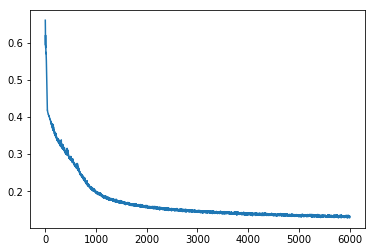

In [23]:
torch.backends.cudnn.benchmark=True
dtype = torch.cuda.FloatTensor
n_epochs = 20000
e_losses = []
former_loss = 9999999999999999999999999999

for epoch in range(n_epochs):
    
    # forward pass
    outputs = model.forward(X_train)

    # calculate loss (MSE)
    loss = criterion(outputs, Y_train)
    e_losses.append(loss.data)

    # compute gradients
    loss.backward()
    
    # perform one step in the oposite direction to the gradient (update weights)
    optimizer.step()
    
    # clear gradient values after weights are updated
    optimizer.zero_grad()
    
    if loss <= min(e_losses):
        torch.save(model.state_dict(), '.\models\model_pytorch.pt')
        last_epoch = epoch
        last_loss = loss.item()
        
    if epoch % 500 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
        current_loss = loss.item()
        if former_loss - current_loss < 0:
            print('early stopping at epoch {}, model saved at epoch {}, with loss {}'.format(epoch, last_epoch, last_loss))
            break
        else:
            former_loss = current_loss

plt.style.use(['dark_background'])        
plt.plot(e_losses)

In [24]:
def predict_new_data(x_test, y_test, model):
    # switch to evaluation mode
    model = model.eval()

    with torch.no_grad():
        y_pred = model.forward(x_test).cpu().numpy()

    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(int)
    y_test = y_test.cpu().numpy()
    accuracy = metrics.accuracy_score(y_pred, y_test).astype(str)
    print('\n\naccuracy is ' + accuracy)

    precision = metrics.precision_score(y_test, y_pred).astype(str)
    print('precision is ' + precision)
    recall = metrics.recall_score(y_test, y_pred).astype(str)
    print('recall is ' + recall)
    auc = metrics.roc_auc_score(np.asarray(y_test), y_pred).astype(str)
    print('auc is ' + auc)

    f1 = 2*((precision.astype(np.float64)*recall.astype(np.float64))/(precision.astype(np.float64)+recall.astype(np.float64)))
    print('f1-score is ' + f1.astype(str))
    
    return y_pred

y_pred_train = predict_new_data(X_train, Y_train, model)
y_pred_test = predict_new_data(x_test, y_test, model)



accuracy is 0.9651979319391928
precision is 0.9638898263284962
recall is 0.9889992808246544
auc is 0.9458394571058135
f1-score is 0.976283129995793


accuracy is 0.8009144047687945
precision is 0.8313349320543565
recall is 0.9109005494067999
auc is 0.7095816306356033
f1-score is 0.8693009118541033


In [25]:
## save the model
torch.save(model.state_dict(), r'.\models\pytorch_model.pt')

In [26]:
## clear GPU memory to optimize capacity
torch.cuda.empty_cache()
del X_train, Y_train, x_test, y_test
gc.collect()

44